# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

## Load sequence parameters

In [2]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

In [3]:
nUS = num_spokes
iS = matrix_size[2]//2

In [4]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [5]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [6]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_4_64.h5


In [7]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 4 of 8.


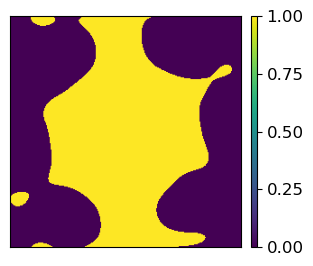

In [8]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

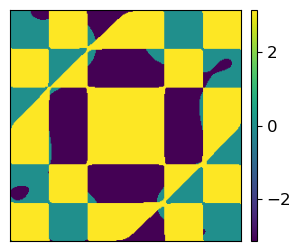

In [9]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [10]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [11]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

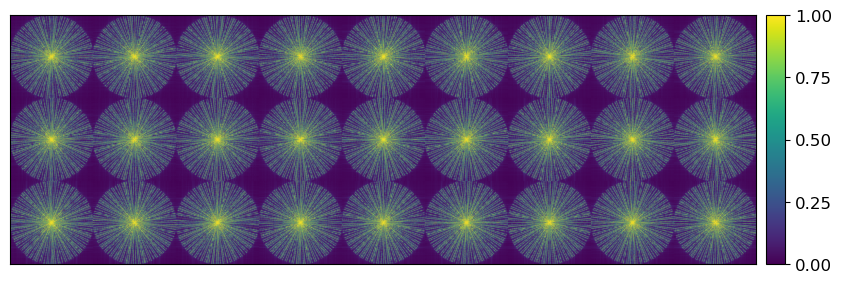

In [12]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

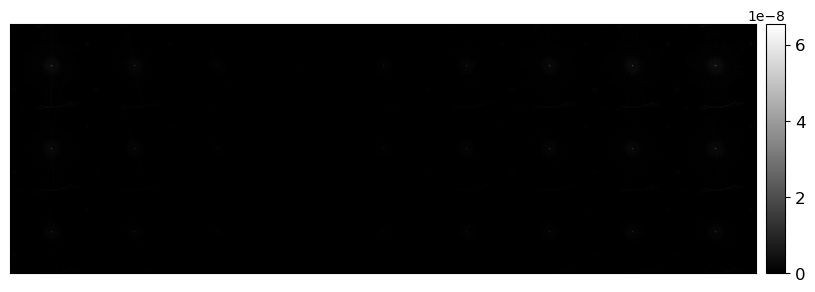

In [22]:
MultiPlotter(
    np.abs(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

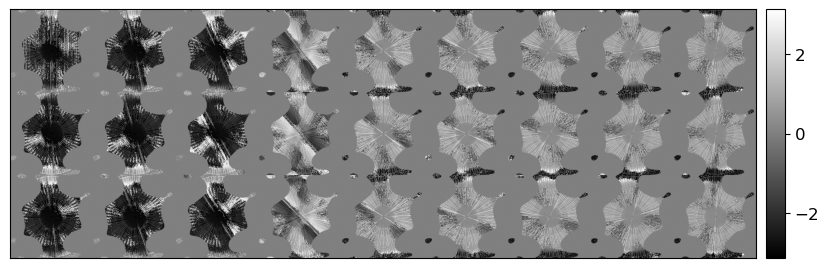

In [14]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [15]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [16]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 2.32E-07 Dual Res: 2.32E-07 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 8.84E-08 Dual Res: 1.49E-07 Rel Res: 1.00E+00:   7%|▋         | 2/30 [00:02<00:35,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.255e+00


[ADMM] Iter: 02 Prim Res: 4.33E-08 Dual Res: 5.35E-08 Rel Res: 1.00E+00:  10%|█         | 3/30 [00:03<00:33,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.238e+00


[ADMM] Iter: 03 Prim Res: 3.04E-08 Dual Res: 1.73E-08 Rel Res: 1.00E+00:  13%|█▎        | 4/30 [00:04<00:32,  1.23s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.211e+00


[ADMM] Iter: 04 Prim Res: 2.45E-08 Dual Res: 8.21E-09 Rel Res: 1.00E+00:  17%|█▋        | 5/30 [00:06<00:30,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.243e+00


[ADMM] Iter: 05 Prim Res: 2.09E-08 Dual Res: 4.72E-09 Rel Res: 1.00E+00:  20%|██        | 6/30 [00:07<00:29,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.245e+00


[ADMM] Iter: 06 Prim Res: 1.83E-08 Dual Res: 3.23E-09 Rel Res: 1.00E+00:  23%|██▎       | 7/30 [00:08<00:28,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.239e+00


[ADMM] Iter: 07 Prim Res: 1.64E-08 Dual Res: 2.44E-09 Rel Res: 1.00E+00:  27%|██▋       | 8/30 [00:09<00:27,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.241e+00


[ADMM] Iter: 08 Prim Res: 1.47E-08 Dual Res: 1.95E-09 Rel Res: 1.00E+00:  30%|███       | 9/30 [00:11<00:26,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.260e+00


[ADMM] Iter: 09 Prim Res: 1.34E-08 Dual Res: 1.60E-09 Rel Res: 1.00E+00:  33%|███▎      | 10/30 [00:12<00:24,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.245e+00


[ADMM] Iter: 10 Prim Res: 1.23E-08 Dual Res: 1.34E-09 Rel Res: 1.00E+00:  37%|███▋      | 11/30 [00:13<00:23,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.243e+00


[ADMM] Iter: 11 Prim Res: 1.13E-08 Dual Res: 1.14E-09 Rel Res: 1.00E+00:  40%|████      | 12/30 [00:14<00:22,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.243e+00


[ADMM] Iter: 12 Prim Res: 1.04E-08 Dual Res: 9.79E-10 Rel Res: 1.00E+00:  43%|████▎     | 13/30 [00:16<00:21,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.250e+00


[ADMM] Iter: 13 Prim Res: 9.70E-09 Dual Res: 8.54E-10 Rel Res: 1.00E+00:  47%|████▋     | 14/30 [00:17<00:19,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.242e+00


[ADMM] Iter: 14 Prim Res: 9.03E-09 Dual Res: 7.51E-10 Rel Res: 1.00E+00:  50%|█████     | 15/30 [00:18<00:18,  1.21s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.133e+00


[ADMM] Iter: 15 Prim Res: 8.42E-09 Dual Res: 6.69E-10 Rel Res: 1.00E+00:  53%|█████▎    | 16/30 [00:19<00:16,  1.19s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.149e+00


[ADMM] Iter: 16 Prim Res: 7.87E-09 Dual Res: 5.99E-10 Rel Res: 1.00E+00:  57%|█████▋    | 17/30 [00:20<00:15,  1.18s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.136e+00


[ADMM] Iter: 17 Prim Res: 7.37E-09 Dual Res: 5.41E-10 Rel Res: 1.00E+00:  60%|██████    | 18/30 [00:21<00:13,  1.16s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.135e+00


[ADMM] Iter: 18 Prim Res: 6.91E-09 Dual Res: 4.92E-10 Rel Res: 1.00E+00:  63%|██████▎   | 19/30 [00:23<00:12,  1.16s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.137e+00


[ADMM] Iter: 19 Prim Res: 6.48E-09 Dual Res: 4.49E-10 Rel Res: 1.00E+00:  67%|██████▋   | 20/30 [00:24<00:11,  1.11s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.020e+00


[ADMM] Iter: 20 Prim Res: 6.09E-09 Dual Res: 4.13E-10 Rel Res: 1.00E+00:  70%|███████   | 21/30 [00:25<00:09,  1.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.016e+00


[ADMM] Iter: 21 Prim Res: 5.73E-09 Dual Res: 3.81E-10 Rel Res: 1.00E+00:  73%|███████▎  | 22/30 [00:26<00:08,  1.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.016e+00


[ADMM] Iter: 22 Prim Res: 5.39E-09 Dual Res: 3.52E-10 Rel Res: 1.00E+00:  77%|███████▋  | 23/30 [00:27<00:07,  1.06s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.044e+00


[ADMM] Iter: 23 Prim Res: 5.07E-09 Dual Res: 3.27E-10 Rel Res: 1.00E+00:  80%|████████  | 24/30 [00:28<00:06,  1.04s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.007e+00


[ADMM] Iter: 24 Prim Res: 4.77E-09 Dual Res: 3.04E-10 Rel Res: 1.00E+00:  83%|████████▎ | 25/30 [00:29<00:05,  1.04s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.016e+00


[ADMM] Iter: 25 Prim Res: 4.49E-09 Dual Res: 2.83E-10 Rel Res: 1.00E+00:  87%|████████▋ | 26/30 [00:30<00:03,  1.00it/s]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  9.083e-01


[ADMM] Iter: 26 Prim Res: 4.23E-09 Dual Res: 2.66E-10 Rel Res: 1.00E+00:  90%|█████████ | 27/30 [00:31<00:02,  1.03it/s]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  9.112e-01


[ADMM] Iter: 27 Prim Res: 3.99E-09 Dual Res: 2.48E-10 Rel Res: 1.00E+00:  93%|█████████▎| 28/30 [00:31<00:01,  1.05it/s]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  9.072e-01


[ADMM] Iter: 28 Prim Res: 3.76E-09 Dual Res: 2.33E-10 Rel Res: 1.00E+00:  97%|█████████▋| 29/30 [00:32<00:00,  1.07it/s]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  9.082e-01


[ADMM] Iter: 29 Prim Res: 3.54E-09 Dual Res: 2.18E-10 Rel Res: 1.00E+00: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  9.383e-01


tensor([ 2.5015e-17, -5.6840e-18, -2.1491e-18,  ..., -4.2449e-18,
         1.0763e-17, -2.3084e-17])

In [17]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_6939/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


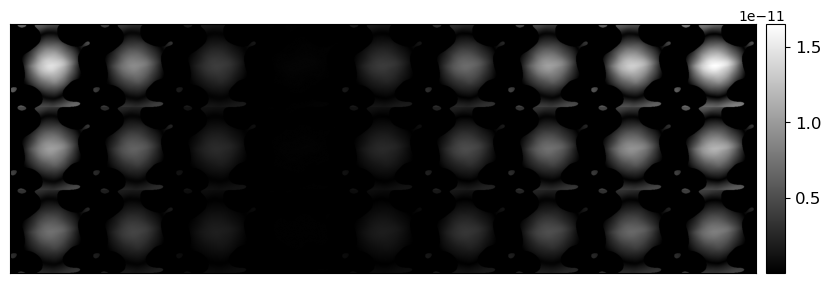

In [18]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [19]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [20]:
# plt.savefig(os.path.join(filepath, 'reconstruction_idea.png'), dpi=1200, transparent=True)